In [1]:
import tensorflow as tf
import logging
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16

In [2]:
# Define dataset paths
TRAIN_DIR = '../data/processed/train/'
TEST_DIR = '../data/processed/test/'
VAL_DIR = '../data/processed/val/'
IMG_SIZE = (224,224)
BATCH_SIZE = 32

In [3]:
# Image preprocessing using image_dataset_from_directory
train_data = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    label_mode='binary',
    seed=42
)

Found 125 files belonging to 2 classes.


In [4]:
class_names = train_data.class_names  # Get class names before transformations
print(class_names)

['no_tumor', 'tumor']


In [5]:
test_data = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    label_mode='binary',
    seed=42
)

Found 27 files belonging to 2 classes.


In [6]:
val_data = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    label_mode='binary',
    seed=42
)

Found 27 files belonging to 2 classes.


In [7]:
# Optimize dataset performance
AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
# VGG16 Model with transfer learning
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the convolutional base

In [9]:
# Custom classifier
top_model = models.Sequential([
    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])


In [10]:
# Combine VGG16 and classifier
model = models.Sequential([base_model, top_model])

In [11]:
top_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 6,423,041
Trainable params: 6,423,041
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 sequential (Sequential)     (None, 1)                 6423041   
                                                                 
Total params: 21,137,729
Trainable params: 6,423,041
Non-trainable params: 14,714,688
_________________________________________________________________


In [13]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Lower learning rate
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [14]:
def save_model_architecture(model, filepath="model_vgg_cnn.png"):
    tf.keras.utils.plot_model(model, to_file=filepath, show_shapes=True)
    print(f"Model architecture saved to {filepath}")
save_model_architecture(model)

Model architecture saved to model_vgg_cnn.png


In [15]:
# Train the model
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(train_data, validation_data=val_data, epochs=20, callbacks=[early_stopping])

Epoch 1/20


2025-04-06 16:28:16.707236: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


4/4 [==============================] - 15s 4s/step - loss: 11.7549 - accuracy: 0.6000 - val_loss: 9.1391 - val_accuracy: 0.5556
Epoch 2/20
4/4 [==============================] - 15s 4s/step - loss: 10.8950 - accuracy: 0.5760 - val_loss: 8.7954 - val_accuracy: 0.5556
Epoch 3/20
4/4 [==============================] - 15s 4s/step - loss: 10.9999 - accuracy: 0.6320 - val_loss: 8.3191 - val_accuracy: 0.5926
Epoch 4/20
4/4 [==============================] - 14s 4s/step - loss: 10.3858 - accuracy: 0.6640 - val_loss: 7.7320 - val_accuracy: 0.7037
Epoch 5/20
4/4 [==============================] - 15s 4s/step - loss: 9.2474 - accuracy: 0.6800 - val_loss: 7.3373 - val_accuracy: 0.6667
Epoch 6/20
4/4 [==============================] - 15s 4s/step - loss: 7.5288 - accuracy: 0.7920 - val_loss: 7.3205 - val_accuracy: 0.7407
Epoch 7/20
4/4 [==============================] - 16s 4s/step - loss: 7.7290 - accuracy: 0.7520 - val_loss: 7.3539 - val_accuracy: 0.7778
Epoch 8/20
4/4 [=========================

In [16]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

1/1 [==============================] - 3s 3s/step - loss: 6.6998 - accuracy: 0.8148
Test Accuracy: 81.48%


In [17]:
# Generate predictions and confusion matrix
y_pred = []
y_true = []
for images, labels in test_data:
    predictions = model.predict(images)
    pred_classes = (predictions > 0.5).astype(int).flatten()  # Convert to binary class (0 or 1)
    y_pred.extend(pred_classes)
    y_true.extend(labels.numpy())

1/1 [==============================] - 3s 3s/step


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

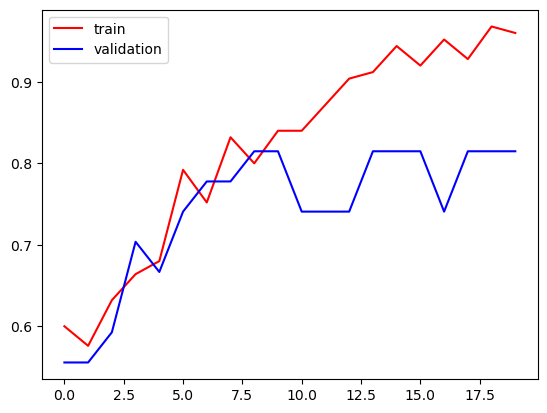

In [19]:
plt.plot(history.history['accuracy'], color = 'red', label = 'train')
plt.plot(history.history['val_accuracy'], color = 'blue', label = 'validation')
plt.legend()
plt.show()

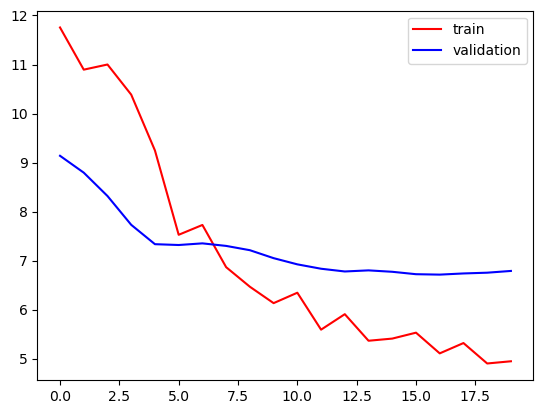

In [20]:
plt.plot(history.history['loss'], color = 'red', label = 'train')
plt.plot(history.history['val_loss'], color = 'blue', label = 'validation')
plt.legend()
plt.show()

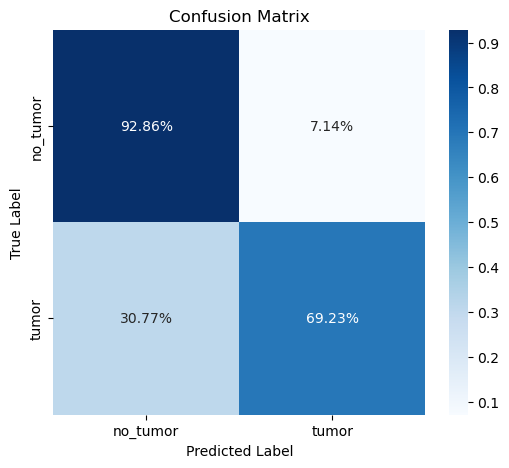

In [21]:
# Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize by row

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_percentage, annot=True, fmt=".2%", cmap='Blues', xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [22]:
# Save the model
model.save("VGG_CNN_model.h5")

1/1 [==============================] - 3s 3s/step


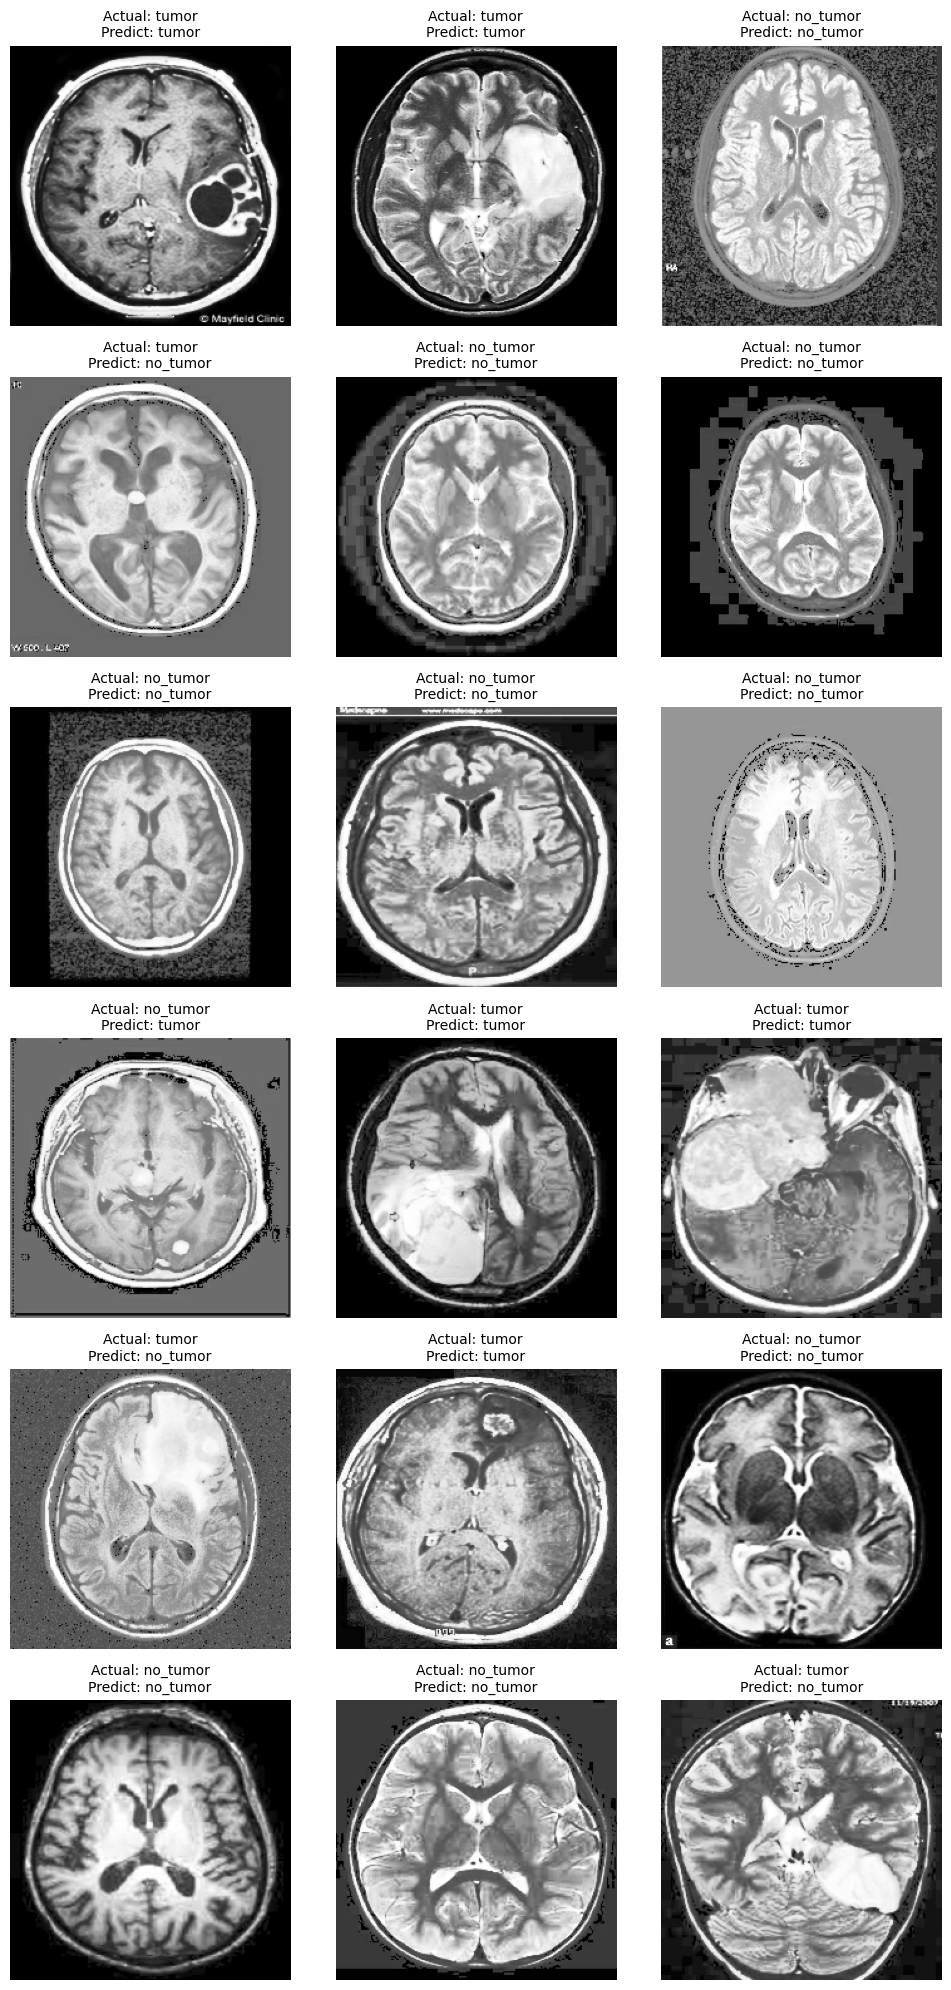

In [23]:
# Generate predictions
y_pred = model.predict(test_data)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()  # Convert to binary class (0 or 1)

# Plot images with actual and predicted labels
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(10, 20))
index = 0

for image, label in test_data.unbatch():
    if index >= 18:  # Stop after displaying 18 images
        break

    # Convert image tensor to numpy array
    image = image.numpy().squeeze()  # Remove extra dimensions if grayscale
    label = int(label.numpy().item())  # Extract scalar value properly

    # Access the current subplot
    ax = axes.flat[index]

    # Display the image
    if image.ndim == 2:  # If grayscale
        ax.imshow(image, cmap='gray')
    else:  # If RGB
        ax.imshow(image.astype("uint8"))

    # Get actual and predicted class names
    actual_class = class_names[label]
    predicted_class = class_names[y_pred_classes[index]]

    # Set title and remove axis
    ax.set_title(f'Actual: {actual_class}\nPredict: {predicted_class}', fontsize=10)
    ax.axis('off')

    index += 1  # Move to the next subplot

plt.tight_layout()
plt.show()
